## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169701, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.36734679941546833,
 0.36635254913207965,
 0.3666278799797873,
 0.36669989939134046,
 0.366681143387826,
 0.3669507381762064,
 0.36680105434233357,
 0.3651792973782567,
 0.3657543600879529,
 0.3660079303296414]

## Train CNN-LSTM model using full data set

In [7]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
btc_model.sats2model()

In [8]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220625_16_16'

In [9]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220624_16_16"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, epochs=20)

Epoch 1/20
11/11 [==============================] - 21s 522ms/step - loss: 0.2051 - val_loss: 0.1473
Epoch 2/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0552 - val_loss: 0.0782
Epoch 3/20
11/11 [==============================] - 1s 99ms/step - loss: 0.0372 - val_loss: 0.0681
Epoch 4/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0203 - val_loss: 0.0306
Epoch 5/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0544 - val_loss: 0.0074
Epoch 6/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0415 - val_loss: 0.0081
Epoch 7/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0324 - val_loss: 0.0552
Epoch 8/20
11/11 [==============================] - 1s 99ms/step - loss: 0.0203 - val_loss: 0.0251
Epoch 9/20
11/11 [==============================] - 1s 100ms/step - loss: 0.0167 - val_loss: 0.0147
Epoch 10/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0168 - val_loss: 0.0085
Epoc

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


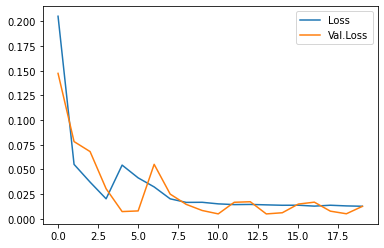

In [10]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [11]:
btc_model.sats2train(model_name, epochs=100)

Epoch 1/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 2/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0125 - val_loss: 0.0040
Epoch 3/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0122 - val_loss: 0.0083
Epoch 4/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 5/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0120 - val_loss: 0.0155
Epoch 6/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0122 - val_loss: 0.0064
Epoch 7/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0123 - val_loss: 0.0063
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0121 - val_loss: 0.0130
Epoch 9/100
11/11 [==============================] - 1s 103ms/step - loss: 0.0118 - val_loss: 0.0125
Epoch 10/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0117 - val_loss: 

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


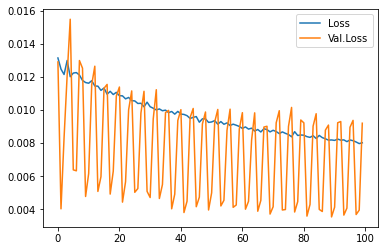

In [12]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [13]:
btc_model.sats2pred()

In [14]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

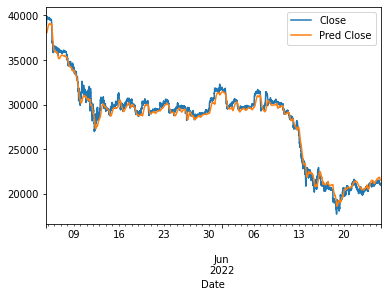

In [18]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 0)
df_preds_true.dropna().plot()

## Test on pretrained model

In [19]:
USE_PRETRAINED = False

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.5213111 ],
       [0.5212589 ],
       [0.52128494],
       ...,
       [0.37105337],
       [0.3706848 ],
       [0.3705142 ]], dtype=float32)

In [20]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

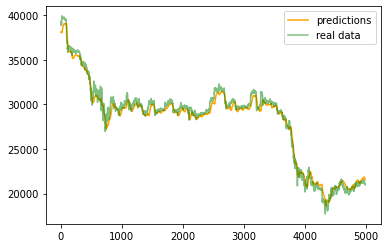

In [21]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

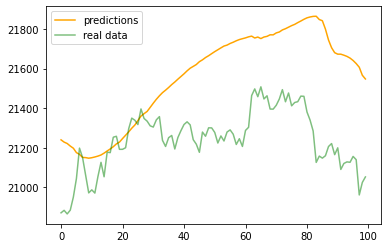

In [22]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

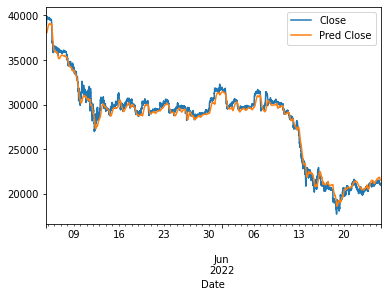

In [24]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 0)
df_preds_true.dropna().plot()

In [25]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-05-04 15:31:00,38908.10,38110.080552
2022-05-04 15:46:00,38973.20,38104.345846
2022-05-04 16:01:00,39019.99,38107.206652
2022-05-04 16:16:00,39316.87,38111.592786
2022-05-04 16:31:00,39198.96,38094.362483
...,...,...
2022-06-25 15:16:00,21156.45,21641.099422
2022-06-25 15:31:00,21140.01,21625.702131
2022-06-25 15:46:00,20961.89,21607.047971


In [26]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back:])

array([38908.1 , 38973.2 , 39019.99, ..., 20961.89, 21025.05, 21052.9 ])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Fee: 0.025
----------------------
Buy      384 ( 228 ok 156 ko )
Avg PCT gain: 1.0057402258100536
Avg PCT loss: 0.9953255672872322
Wins     0.07686148919135308
Avg Gain.    1.4615384615384615
No-op    4612
Wallet   11945.664999999999
Drawback -927.1227499999984
Kelly Fraction    -0.898844340314509
Total earned 11945.664999999999


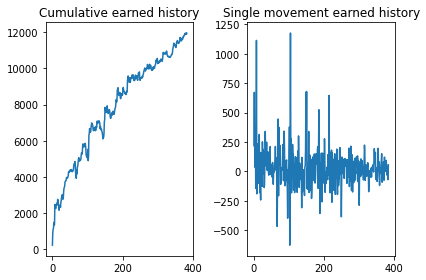

In [37]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

Fee: 0.025
----------------------
Buy      1646 ( 934 ok 712 ko )
Wallet   28124.786250000005
Drawback -1549.9947499999987
Total earned 28124.786250000005


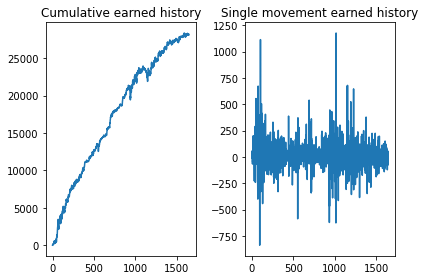

In [56]:
total_wallet_history, single_wallet_history, wallet = s2b.backtest_debug(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)